<a href="https://colab.research.google.com/github/DeepkMenon/ZTM-ML-Model/blob/main/ZTM_Colab_1_%5BDog_Vision%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np


In [ ]:
#!unzip "drive/MyDrive/ZTM- Vision/dog-breed-identification.zip" -d "drive/MyDrive/ZTM- Vision"

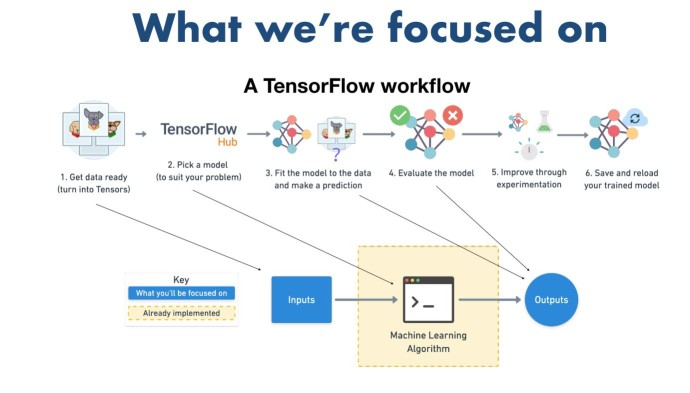



# 🐶 End-to-end Multil-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.x and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.


## 2. Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data 

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels).
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them). 


### Get workspace ready

* Import TensorFlow 2.x ✅
* Import TensorFlow Hub ✅
* Make sure we're using a GPU ✅

In [2]:
# # Import TensorFlow into Colab
# import tensorflow as tf
# print("TF version:", tf.__version__)

In [3]:
import tensorflow as tf
import tensorflow_hub as hub 
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

TF version: 2.6.0
TF Hub version: 0.12.0


In [4]:
 #Check for GPU availability
print("GPU", "available (YESSSS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU not available :(


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [5]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/ZTM- Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     75698e8be83cb8e8cf6e2011d29b07ee  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [6]:
labels_csv.tail()

,id,breed
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher
10221,fff43b07992508bc822f33d8ffd902ae,chesapeake_bay_retriever


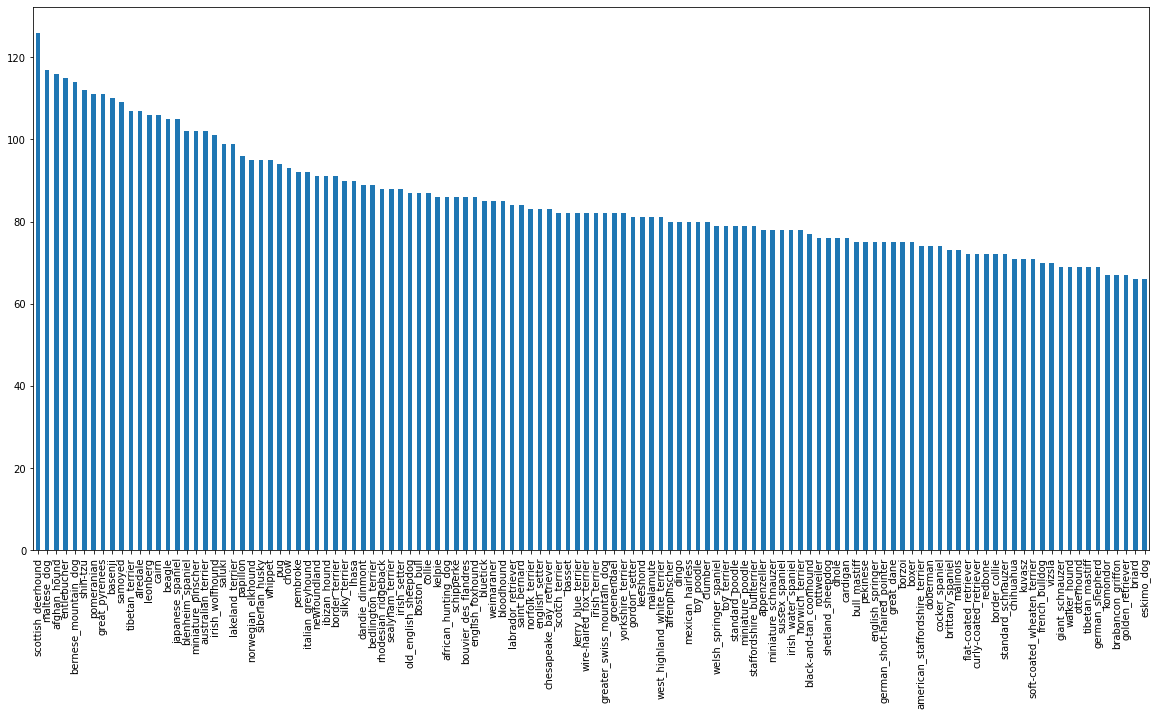

In [7]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [8]:
# What's the median number of images per class?
labels_csv["breed"].value_counts().median()

82.0

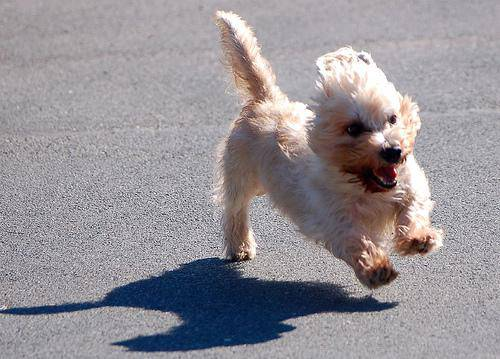

In [ ]:
# Let's view an image
from IPython.display import Image
Image('drive/MyDrive/ZTM- Vision/train/ffd3f636f7f379c51ba3648a9ff8254f.jpg') 
  

In [9]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
labels_csv.head()



,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [11]:
# Create pathnames from image ID's
filenames = ["drive/MyDrive/ZTM- Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

#Check the first 10
filenames[:10]

['drive/MyDrive/ZTM- Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/ZTM- Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/ZTM- Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/ZTM- Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/ZTM- Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/ZTM- Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/ZTM- Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/ZTM- Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/ZTM- Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/ZTM- Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [12]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/MyDrive/ZTM- Vision/train/")) == len(filenames):
  print("Filenames match actual amount of files!!! Proceed.")
else:
  print("Filenames do no match actual amount of files, check the target directory.")

Filenames match actual amount of files!!! Proceed.


Since we've now got our training image filepaths in a list, let's prepare our labels.

In [13]:
type(labels_csv["breed"])

pandas.core.series.Series

In [14]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels) # does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [15]:
len(labels)

10222

In [16]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filenames!


In [17]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [18]:
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

Since ML models cant take **strings**  as input , we need to convert the labels into some other format.

For that we  need to convert each of the labels into a **boolean array**. 

What this means is that for every label there would be one **true** value that is associated with it. The rest will be **false**.


---


If we take the case of label[0], which is **boston bull**, only the 12thish value is true. The rest is false.

Ithiri confusing aa.. 😕




In [19]:
#Turn a single label into an array of booleans
print(labels[0])

labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

Now we need to turn **EVERY** label into a boolean array

In [20]:
len(labels)

10222

In [21]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:3]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [22]:
print(len(labels))
print(len(boolean_labels))

10222
10222


In [23]:
#Example Turning boolean arary into integers
print(labels[0]) #original label..staright from labels.csv 
print(np.where(unique_breeds== labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs 

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


Now, **Every** single label in boolean_labels is going to be converted into the 0,1 format.


---



---



 ### Creating our own validation set
Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

We'll train the ML model on the training set. We'll then evaluate it on a validation set  to see if the experiments that we are doing on the training set are going alright.

Then we have the test set. So we would like to have that intermediate validation set to validate our initial experiments.

For that we will be splitting the training data set into another train and test(validation) set.   

In [24]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [32]:
#X[:1000]

In [34]:
print(len(X))
print(len(y))

10222
10222


We're going to start off experimenting with ~1000 images and increase as needed.

In [26]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [35]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [36]:
#Lets have a geez at the training data
X_train[:5], y_train[:2]

(['drive/MyDrive/ZTM- Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/ZTM- Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/ZTM- Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/ZTM- Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/ZTM- Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, Fa

## Preprocessing Images (turning images into Tensors)

#### This is something that we have to do even if it is an audio file i.e, converting them into tensors for Tensorflow.

Our labels are in numeric format but our images are still just file paths.

Since we're using TensorFlow, our data has to be in the form of Tensors.

A Tensor is a way to represent information in numbers. If you're familar with NumPy arrays (you should be), a Tensor can be thought of as a combination of NumPy arrays, except with the special ability to be used on a GPU.

Because of how TensorFlow stores information (in Tensors), it allows machine learning and deep learning models to be run on GPUs (generally faster at numerical computing).

To preprocess our images into Tensors we're going to write a function which does a few things:

1. Takes an image filename as input.
2. Uses TensorFlow to read the file and save it to a variable, `image`.
3. Turn our `image` (a jpeg file) into Tensors.
4. Normalize our image( convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be of shape (224, 224).
6. Return the modified `image`.


A good place to read about this type of function is the [TensorFlow documentation on loading images](https://www.tensorflow.org/tutorials/load_data/images). 


In [37]:
#Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])# read in an image
image.shape

(257, 350, 3)

Here *filenames* is the list of filepaths for the training dataset(original one)

And the *image* is the image from that filepath[here it is 42nd image]. The values : (257,350,3) are the height, width and color channel.


---



---


**Color Channel :** A color channel stores the color information for one of the primary color components of a color model. For example, the RGB color model has three separate color channels; one for red, one for green and one for blue.

In [38]:
image.max(), image.min()

(255, 0)

In [39]:
image.shape

(257, 350, 3)

In [40]:
image # At the moment it is in a numpy array

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  53],
        [ 97,  88,  49],
        [120, 111,  72]]

We can easily convert it to a Tensor using [`tf.constant()`](https://www.tensorflow.org/api_docs/python/tf/constant).

All tensors are immutable like Python numbers and strings: you can never update the contents of a tensor, only create a new one.

In [41]:
#turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

----------------------------------
Now lets build the function that we were talking about : 
1. Takes an image filename as input.
2. Uses TensorFlow to read the file and save it to a variable, `image`.
3. Turn our `image` (a jpeg file) into Tensors.
4. Normalize our image( convert color channel values from 0-255 to 0-1).
5. Resize the `image` to be of shape (224, 224).
6. Return the modified `image`.

We might be wondering why (224, 224), which is (heigh, width). It's because this is the size of input our model (we'll see this soon) takes, an image which is (224, 224, 3).




The function is named as **process_image**

In [42]:
# Define image size
IMG_SIZE = 224
def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image= tf.image.resize(image,size=[IMG_SIZE, IMG_SIZE])

  return image
 

#### WALKTHROUGH OF THE ABOVE FN




In [ ]:
tensor= tf.io.read_file(filenames[42])
"""
     What this does is that it takes in an image path and converts it into 
     a string like object that the compiler can understand.
"""
tensor

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\n\x07\x07\x08\x07\x06\n\x08\x08\x08\x0b\n\n\x0b\x0e\x18\x10\x0e\r\r\x0e\x1d\x15\x16\x11\x18#\x1f%$"\x1f"!&+7/&)4)!"0A149;>>>%.DIC<H7=>;\xff\xdb\x00C\x01\n\x0b\x0b\x0e\r\x0e\x1c\x10\x10\x1c;("(;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\xff\xc0\x00\x11\x08\x01\x01\x01^\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca

In [ ]:
tensor= tf.image.decode_jpeg(tensor, channels=3)  


Now, we will do normalization on the image that has been converted into tensors.

**Normalization :** In simple terms, it is the conversion of the range of values to another range(0-1)

In [ ]:
 # Convert the colour channel values from 0-225 values to 0-1 values
 tensor= tf.image.convert_image_dtype(tensor, tf.float32)
 tensor

<tf.Tensor: shape=(257, 350, 3), dtype=float32, numpy=
array([[[0.34509805, 0.5411765 , 0.34117648],
        [0.29411766, 0.4901961 , 0.2901961 ],
        [0.24705884, 0.43529415, 0.23137257],
        ...,
        [0.29803923, 0.5254902 , 0.32941177],
        [0.29803923, 0.5254902 , 0.3372549 ],
        [0.29411766, 0.52156866, 0.33333334]],

       [[0.2784314 , 0.47058827, 0.28627452],
        [0.25490198, 0.45098042, 0.25882354],
        [0.24313727, 0.43921572, 0.24705884],
        ...,
        [0.28627452, 0.5137255 , 0.3254902 ],
        [0.2901961 , 0.5176471 , 0.32941177],
        [0.2901961 , 0.5176471 , 0.32941177]],

       [[0.21176472, 0.41176474, 0.2509804 ],
        [0.21960786, 0.41960788, 0.25882354],
        [0.24313727, 0.4431373 , 0.28235295],
        ...,
        [0.27450982, 0.49803925, 0.32156864],
        [0.2784314 , 0.5019608 , 0.3254902 ],
        [0.28235295, 0.5058824 , 0.32941177]],

       ...,

       [[0.00784314, 0.04313726, 0.03921569],
        [0.01

In [ ]:
# Resize the image to our desired value (224, 224)
tensor = tf.image.resize(tensor, size=[224, 224])


"""
 On running the above code, we can see that the shape has been 
 converted from (257,350,3) to (224,224,3) 
"""
tensor

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.3264178 , 0.5222886 , 0.3232816 ],
        [0.2537167 , 0.44366494, 0.24117757],
        [0.25699762, 0.4467087 , 0.23893751],
        ...,
        [0.29325107, 0.5189916 , 0.3215547 ],
        [0.29721776, 0.52466875, 0.33030328],
        [0.2948505 , 0.5223015 , 0.33406618]],

       [[0.25903144, 0.4537807 , 0.27294815],
        [0.24375686, 0.4407019 , 0.2554778 ],
        [0.2838985 , 0.47213382, 0.28298813],
        ...,
        [0.2785345 , 0.5027992 , 0.31004712],
        [0.28428748, 0.5108719 , 0.32523635],
        [0.28821915, 0.5148036 , 0.32916805]],

       [[0.20941195, 0.40692952, 0.25792548],
        [0.24045378, 0.43900946, 0.2868911 ],
        [0.29001117, 0.47937486, 0.32247734],
        ...,
        [0.26074055, 0.48414773, 0.30125174],
        [0.27101526, 0.49454468, 0.32096273],
        [0.27939945, 0.5029289 , 0.32934693]],

       ...,

       [[0.00634795, 0.03442048, 0.0258106 ],
        [0.01

## Turning our data into batches

Wonderful. Now we've got a function to convert our images into Tensors, we'll now build one to turn our data into batches (more specifically, a TensorFlow [`BatchDataset`](https://www.tensorflow.org/guide/data#batching_dataset_elements)).

In deep learning, instead of finding patterns in an entire dataset at the same time, you often find them one batch at a time.


---


### Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: 
`(image, label)`..We  pass 32 of these to our ML model and figure  out the patterns of each image with the label.

In [43]:
def get_image_label(image_path,label):
  """
   Takes an image file path name and the associated label,
   processes  the image and returns a tuple of (image,label).
  """
  image= process_image(image_path)
  return image,label

In [44]:
#Demo of the above
"""
This would return a tuple that consists of the image[42] that has been converted 
into tensors and the label of image[42]
"""
tup=(process_image(X[42]),y[42])
tup

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [45]:
type(tup)

tuple

Now we've got a simple function to turn our image file path names and their associated labels into tuples (we can turn these into Tensors next), we'll create a function to make data batches.

Because we'll be dealing with **3 different sets of data** (training, validation and test), we'll make sure the function can accomodate for each set.

We'll set a default batch size of 32 because [according to Yann Lecun](https://twitter.com/ylecun/status/989610208497360896?s=20) (one of the OG's of deep learning), friends don't let friends train with batch sizes over 32.

In [46]:
#Holy..start cheythitte ullu😥
#Define teh batch size , 32 is a good start
BATCH_SIZE= 32

#Create a function to turn data into batches
#Ivide y=None koduthath doubt unde❓
def create_data_batches(X, y=None,batch_size=BATCH_SIZE, valid_data=False,test_data=False):
  """
   Creates batches of data out of image(X) and label(y) pairs.
   Shuffles the data if its training data but doesnt shuffle if its validation data.
   Also accepts test data as inputs (but test data doesnt have labels.)
   -->That's the reason why 'y=None' is specified. 
  """
  # If the data is a test dataset, we probably dont have labels
  if test_data:
    print("Creating test data batches(of size 32)..")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(X)))#only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)# Creates batches from the tf.Dataset
    
    return data_batch

  # If the data is a validation dataset(THIS HAS LABELS), we dont need to shuffle it 
  elif valid_data:
    print("Creating validation data batches...")
    # Now here we need to create a dataset from the tuple of (image_filepaths,label) 
    data= tf.data.Dataset.from_tensor_slices((tf.constant(X),#filepaths 
                                              tf.constant(y) #labels
                                              ))
    data_batch= data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

   #Else this  is a training set  
  else:
    print('Creating training data batches...')
    # Turn filepaths and labels into Tensors
    data= tf.data.Dataset.from_tensor_slices((tf.constant(X),#filepaths 
                                              tf.constant(y) #labels
                                              ))
    #Shuffling pathnames and labels before mapping image processor function 
    # is faster than shuffling images
    data= data.shuffle(buffer_size=len(X))

    # We can shuffle the images after it has been processed, 
    # but it takes longer to shuffle images than the pathnames   
    
    #Create (image,label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label) # This get_image_label fn has the process_image fn
                                     # included into it🥱.

    data_batch = data.batch(BATCH_SIZE)
    
    return data_batch



### EXPLANATION OF SOME OF THE STUFF FROM ABOVE CODE


---
1) The `data.map(process_image)` will take each tensor from the `tf.dataset` 
created above and apply the `process_image` fn that is used to turn the image into tensors and into certain dimensions.  

 `.batch()` is then performed on that processed data item and converted into batch of 32.

 2) 
> For test data, we only need the filepaths (no labels).


   >  For valid data, we need both filepaths and labels. 

> For training set, we need to shuffle the data(pathnames,labels)



    




#### Now we will create the training, validation data batches using the fn above.

In [47]:
# Create training and validation data batches
train_data= create_data_batches(X_train,y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)# This is true since it is the validation set.


Creating training data batches...
Creating validation data batches...


In [48]:
# Check out the different attributes of our data batches
"""element_spec
     --> The type specification of an element of this dataset.
"""     
train_data.element_spec, val_data.element_spec


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

The first two rows:

`((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),`
  -->This is the training data image

 ` TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),`
  --> This is the training data label

`(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),`
  --> This is the valid_data image
  
  `TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))` 
  --> This is the validation data label 


Look at that! We've got our data in batches, more specifically, they're in Tensor pairs of (images, labels) ready for use on a GPU.

But having our data in batches can be a bit of a hard concept to understand. Let's build a function which helps us visualize what's going on under the hood.

### Visualizing data batches

In [49]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images,labels):
  """
   Displays 25 images from a data batch
  """
  # Setup the figure
  plt.figure(figsize=(10,10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots ( 5 rows, 5 columns)
    ax = plt.subplot(5,5,i+1)
    # Display an image in each of the subplots
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")


In [50]:

print(unique_breeds[y[0].argmax()] )# y is the label
print(unique_breeds[y[5].argmax()]) # y is the label


boston_bull
bedlington_terrier


To make computation efficient, a batch is a tighly wound collection of Tensors.

So to view data in a batch, we've got to `unwind` it.

We can do so by calling the [`as_numpy_iterator()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#as_numpy_iterator) method on a data batch.

This will turn our a data batch into something which can be iterated over.

Passing an iterable to [`next()`](https://docs.python.org/3/library/functions.html#next) will return the next item in the iterator.

In our case, next will return a batch of 32 images and label pairs.

**Note:** Running the cell below and loading images may take a little while.

In [51]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [52]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [53]:
train_images, train_labels= next(train_data.as_numpy_iterator())
#train_images, train_labels

In [54]:
len(train_images), len(train_labels)

(32, 32)

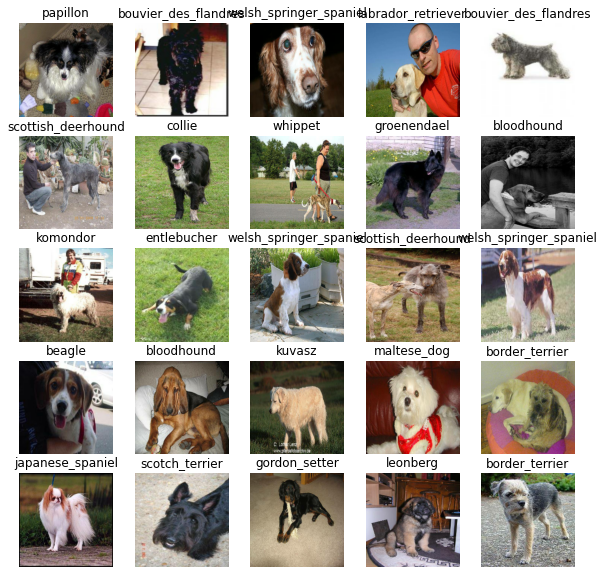

In [55]:
 # Now lets visualize the data in a training batch
 show_25_images(train_images,train_labels)

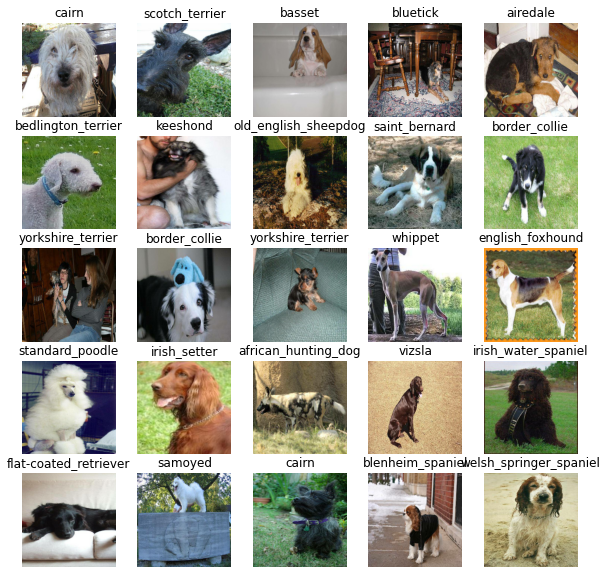

In [56]:
# Visualize validation images from the validation data batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

Why does running the cell above and viewing validation images return the same dogs each time?

## SECTION 1 [Getting Data Ready] IS COMPLETE ! 

---



## SECTION 2 [ Creating and Training a Model]

Now our data is ready, let's prepare it modelling. We'll use an existing model from [TensorFlow Hub](https://tfhub.dev/).

`TensorFlow Hub is a resource where you can find pretrained machine learning models for the problem you're working on.`

Using a pretrained machine learning model is often referred to as **transfer learning**.

#### Why use a pretrained model?

Building a machine learning model and training it on lots from scratch can be expensive and time consuming.

`Transfer learning helps eliviate some of these by taking what another model has learned and using that information with your own problem.`

#### How do we choose a model?

Since we know our problem is `image classification (classifying different dog breeds)`, we can navigate the [TensorFlow Hub page by our problem domain (image)](https://tfhub.dev/s?module-type=image-augmentation,image-classification,image-feature-vector,image-generator,image-object-detection,image-others,image-style-transfer,image-rnn-agent). 

We start by choosing the image problem domain, and then can filter it down by subdomains, in our case, [image classification](https://tfhub.dev/s?module-type=image-classification).

Doing this gives a list of different pretrained models we can apply to our task.

Clicking on one gives us information about the model as well as instructions for using it.

For example, clicking on the [mobilenet_v2_130_224](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4) model, tells us this model takes an input of images in the shape 224, 224. It also says the model has been trained in the domain of image classification.

Let's try it out.

### Building a model

Before we build a model, there are a few things we need to define:
* The input shape (images, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

These things will be standard practice with whatever machine learning model you use. And because we're using TensorFlow, everything will be in the form of Tensors.

In [59]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"


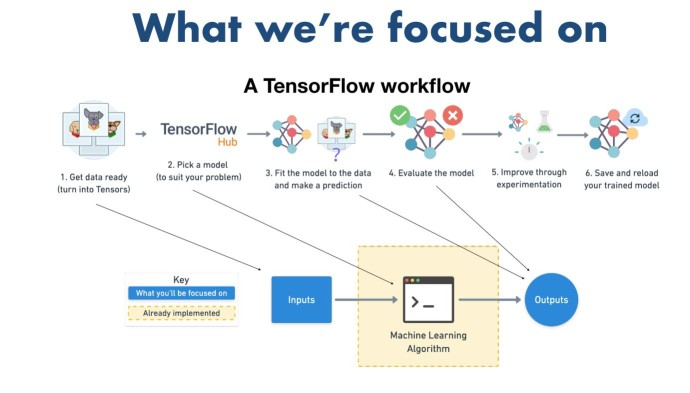

### So far we have covered :
   * Getting data ready
   * Picking a model
   * Define Input
   * Define Outputs 

Now we've got the inputs, outputs and model we're using ready to go. We can start to put them together.

There are many ways of building a model in TensorFlow but one of the best ways to get started is to [use the Keras API](https://www.tensorflow.org/guide/keras/overview).

**Keras** is a deep learning API written in Python, running on top of the machine learning platform TensorFlow. It was developed with a focus on enabling fast experimentation.

Keras is the high-level API of TensorFlow 2: an approachable, highly-productive interface for solving machine learning problems, with a focus on modern deep learning.

Defining a deep learning model in Keras can be as straightforward as saying, `"here are the layers of the model, the input shape and the output shape, let's go!"`

We'll take a look at the code first, then discuss each part.


Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen's URL as parameters.
* Defines the layers in a Keras model in a sequential fashion (do this first, then this, then that).
* Compiles the model (says how it should be evaluated and improved).
* Builds the model (tells it what kind of input shape it'll be getting).
* Returns the model.



In [64]:
#Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with: ",MODEL_URL)
  
  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                          activation="softmax") # Layer 2 (output layer)
  ])

   # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), # A friend telling our model how to improve its guesses
      metrics=["accuracy"] # We'd like this to go up. This is the judge at the bootom of the hill
  )

  # Build the model
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting
  
  return model



What's happening here?

#### Setting up the model layers

There are two ways to do this in Keras, the [functional](https://www.tensorflow.org/guide/keras/functional) and [sequential API](https://www.tensorflow.org/guide/keras/overview#build_a_simple_model). We've used the sequential.

Which one should you use?

The Keras documentation states the functional API is the way to go for defining complex models but the sequential API (a linear stack of layers) is perfectly fine for getting started, which is what we're doing.

The first layer we use is the model from TensorFlow Hub (`hub.KerasLayer(MODEL_URL)`. So our first layer is actually an entire model (many more layers). This **input layer** takes in our images and finds patterns in them based on the patterns [`mobilenet_v2_130_224`](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4) has found.

The next layer (`tf.keras.layers.Dense()`) is the **output layer** of our model. It brings all of the information discovered in the input layer together and outputs it in the shape we're after, 120 (the number of unique labels we have).

The `activation="softmax"` parameter tells the output layer, we'd like to assign a probability value to each of the 120 labels [somewhere between 0 & 1](https://en.wikipedia.org/wiki/Softmax_function). The higher the value, the more the model believes the input image should have that label. If we were working on a binary classification problem, we'd use `activation="sigmoid"`.

For more on which activation function to use, see the article [Which Loss and Activation Functions Should I Use](https://towardsdatascience.com/deep-learning-which-loss-and-activation-functions-should-i-use-ac02f1c56aa8)?

#### Compiling the model

This one is best explained with a story.

Let's say you're at the international hill descending championships. Where your start standing on top of a hill and your goal is to get to the bottom of the hill. The catch is you're blindfolded.

Luckily, your friend Adam is standing at the bottom of the hill shouting instructions on how to get down.

At the bottom of the hill there's a judge evaluating how you're doing. They know where you need to end up so they compare how you're doing to where you're supposed to be. Their comparison is how you get scored.

Transferring this to `model.compile()` terminology:
* `loss` - The height of the hill is the loss function, the models goal is to minimize this, getting to 0 (the bottom of the hill) means the model is learning perfectly.
* `optimizer` - Your friend Adam is the optimizer, he's the one telling you how to navigate the hill (lower the loss function) based on what you've done so far. His name is Adam because the [Adam optimizer](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) is a great general which performs well on most models. Other optimizers include [RMSprop](https://ruder.io/optimizing-gradient-descent/index.html#rmsprop) and [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).
* `metrics` - This is the onlooker at the bottom of the hill rating how well your perfomance is. Or in our case, giving the accuracy of how well our model is predicting the correct image label.

#### Building the model

We use `model.build()` whenever we're using a layer from TensorFlow Hub to tell our model what input shape it can expect.

In this case, the input shape is `[None, IMG_SIZE, IMG_SIZE, 3]` or `[None, 224, 224, 3]` or `[batch_size, img_height, img_width, color_channels]`.

Batch size is left as `None` as this is inferred from the data we pass the model. In our case, it'll be 32 since that's what we've set up our data batches as.

Now we've gone through each section of the function, let's use it to create a model.

We can call `summary()` on our model to get idea of what our model looks like.

In [63]:
#Create a model using the function written above and check its details
model= create_model()
model.summary()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              5432713   
_________________________________________________________________
dense_1 (Dense)              (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


The non-trainable parameters are the patterns learned by `mobilenet_v2_130_224` and the trainable parameters are the ones in the dense layer we added.

This means the main bulk of the information in our model has already been learned and we're going to take that and adapt it to our own problem.

### Creating callbacks

---



We've got a model ready to go but before we train it we'll make some callbacks.

Callbacks are helper functions a model can use during training to do things such as save a models progress, check a models progress or stop training early if a model stops improving.

The two callbacks we're going to add are a TensorBoard callback and an Early Stopping callback.

#### TensorBoard Callback

[TensorBoard](https://www.tensorflow.org/tensorboard/get_started) helps provide a visual way to monitor the progress of your model during and after training.

It can be used [directly in a notebook](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) to track the performance measures of a model such as loss and accuracy.

To set up a TensorBoard callback and view TensorBoard in a notebook, we need to do three things:
1. Load the TensorBoard notebook extension.
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize the our models training logs using the `%tensorboard` magic function (we'll do this later on).

In [67]:
#Load the TensorBoard notebook extension
%load_ext tensorboard

In [70]:
import datetime

#Create a function to build a TensorBoard callback
def create_tensorboard_callback():
    # Create a log directory for storing TensorBoard logs
    logdir = os.path.join("drive/MyDrive/ZTM-Vision/logs",
                           # Make it so the logs get tracked whenever we run an experiment
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logdir)


#### Early Stopping Callback

[Early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) helps prevent overfitting by stopping a model when a certain evaluation metric stops improving. If a model trains for too long, it can do so well at finding patterns in a certain dataset that it's not able to use those patterns on another dataset it hasn't seen before (doesn't generalize).

It's basically like saying to our model, "keep finding patterns until the quality of those patterns starts to go down."

In [72]:
#Create early stopping( once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3 # stops after 3 rounds of no improvements
                                                  )

### Training a model (on a subset of data)
Our first model is only going to be trained on 1000 images. Or trained on 800 images and then validated on 200 images, meaning 1000 images total or about 10% of the total data.

We do this to make sure everything is working. And if it is, we can step it up later and train on the entire training dataset.

The final parameter we'll define before training is `NUM_EPOCHS` (also known as **number of epochs**).

`NUM_EPOCHS` defines how many passes of the data we'd like our model to do. A pass is equivalent to our model trying to find patterns in each dog image and see which patterns relate to each label.

If `NUM_EPOCHS=1`, the model will only look at the data once and will probably score badly because it hasn't a chance to correct itself. It would be like you competing in the international hill descent championships and your friend Adam only being able to give you 1 single instruction to get down the hill.

What's a good value for `NUM_EPOCHS`?

This one is hard to say. 10 could be a good start but so could 100. This is one of the reasons we created an early stopping callback. Having early stopping setup means if we set `NUM_EPOCHS` to 100 but our model stops improving after 22 epochs, it'll stop training.

Along with this, let's quickly check if we're still using a GPU.